# Parsing PDFs 

Pull in all of the PDF files and create objects for the text inside each one. 

This also probably should include a spell check

[One of the sources I am using for the topic modeling](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)
[This is a good post on Lemmatizing in python](https://www.machinelearningplus.com/nlp/lemmatization-examples-python/)

In [1]:
import string 

In [2]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [3]:
import PyPDF2 
from glob import glob

pdfs = glob('../pdfs/*.pdf') 

In [205]:
import os 

In [4]:
pdfs

['../pdfs/Davidson 2018.pdf',
 '../pdfs/Cruz - 2010 - Chapter Six. Expanding The View The Challenges Of.pdf',
 '../pdfs/Cruz - 2010 - Index.pdf',
 '../pdfs/Frederiks and Nagy - 2016 - Religion, migration, and identity methodological .pdf',
 '../pdfs/Zendher 2018.pdf',
 '../pdfs/Jimenez 2019.pdf',
 '../pdfs/Cruz - 2010 - Introduction.pdf',
 '../pdfs/Sarmiento.pdf',
 '../pdfs/Krabill and Norton 2015.pdf',
 '../pdfs/Cruz - 2010 - Chapter One. Geographies Of Domestication Mapping.pdf',
 '../pdfs/Groody2017.pdf',
 '../pdfs/Nacpil 2016.pdf',
 '../pdfs/cruz2010.pdf',
 '../pdfs/Cruz - 2010 - Chapter Two. Frontiers Of Struggle Negotiating Fi.pdf',
 '../pdfs/Theology Compromised 1.pdf',
 '../pdfs/Strine 2018.pdf',
 '../pdfs/Cruz - 2010 - Conclusion.pdf',
 '../pdfs/Nnamani 2015.pdf',
 '../pdfs/Soares et al 2017.pdf',
 '../pdfs/Cruz - 2010 - Chapter Four. Exploring Theological Markers Delor.pdf',
 '../pdfs/Olofinjana 2018.pdf',
 '../pdfs/Thompson 2017.pdf',
 '../pdfs/Cruz - 2010 - An intercultural

# Preparing Texts 

## Lemmatizing and cleaning 

In [6]:
import string
import nltk 
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS 

ADD_PUNC = '”“’’–˙ˆ‘'
STOPWORDS = {'d', 'c', 'e', 's', 'œ', 'dhs', 'hk', 'nagy', 'eology', 'ey', 'g', 'ing', 'tion', 'er', 'rst', 'vol', 'ed'} 
AUTHOR_NAMES = {'cruz', 'frederiks', 'nagy', 'snyder', 'nguyen', 'prior', 'cavanaugh', 'heyer', 'schmil', 'smith', 'groody', 'campese', 'izuzquiza', 'heimburger', 'myers', 'colwell', 'olofinjana', 'krabill', 'norton', 'theocharous', 'nacpil', 'nnamani', 'soares', 'thompson', 'zendher', 'ahn', 'haug', 'sarmiento', 'davidson', 'rowlands', 'strine', 'zink', 'jimenez'}
STOPWORDS = STOPWORDS.union(AUTHOR_NAMES)
STOPWORDS = STOPWORDS.union(ENGLISH_STOP_WORDS)
PUNCDIG_TRANSLATOR = str.maketrans('', '', string.punctuation+string.digits+ADD_PUNC)

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sgoodwin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sgoodwin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
len(STOPWORDS)

367

In [8]:
# New lines should be replaced with space, and African-American becomes africanarmerican 
# Look into both of these.

def text_clean(text):
    clean_list = []
    words = nltk.word_tokenize(text)
    for w in words:
        if w not in STOPWORDS and len(w) > 2: # removing two character words
            w = w.translate(PUNCDIG_TRANSLATOR)
            if w != '':
                clean_list.append(lemmatizer.lemmatize(w))
    return clean_list

In [9]:
text_clean("The striped bats are hanging on their feet3 for best.".lower())

['striped', 'bat', 'hanging', 'foot', 'best']

## Extracting Texts

In [10]:
pdf = open(pdfs[0], 'rb')
pdf_obj = PyPDF2.PdfFileReader(pdf)


In [11]:
print('No. of pages: {}'.format(pdf_obj.numPages))

No. of pages: 19


In [12]:
def pdf_extractor(pdf, corpus_list, text_list):
    '''Extract the text of pdfs and return a dictionary with
    the file name as a key, and the value being a list of the pages
    and the containing texts
    '''
    pdf_file_obj = open(pdf, 'rb')
    pdf_obj = PyPDF2.PdfFileReader(pdf_file_obj)
    for pn in range(0,pdf_obj.numPages):
        page = pdf_obj.getPage(pn)
        text = page.extractText().lower()
        cleaned_list = text_clean(text)
        corpus_list.append(cleaned_list)
        # corpus_list.append(page.extractText())
        text_list.append((pdf, pn))
        # if you want to create a dictionary
        # text_dict.setdefault(pdf, []).append(page.extractText())
    pdf_file_obj.close()
    return corpus_list, text_list

In [13]:
corpus_list = []
text_list = []

for pdf in pdfs:
    corpus_list, text_list = pdf_extractor(pdf, corpus_list, text_list)

In [14]:
len(corpus_list)

1119

# Creating LDA Model 



In [15]:
from gensim import corpora 
from gensim.models.ldamodel import LdaModel 

In [16]:
def prepare_topic_model(corpus_list):
    corpus_dict = corpora.Dictionary(corpus_list)
    corpus_dict.filter_extremes(no_below=100, no_above=0.5)
    corpus = [corpus_dict.doc2bow(text) for text in corpus_list]
    lda_model = LdaModel(corpus=corpus, 
                        id2word=corpus_dict, num_topics=25,
                        random_state=100, update_every=1,
                        chunksize=100, passes=50,
                        alpha='symmetric', per_word_topics=True)
    return lda_model, corpus, corpus_dict

In [17]:
lda_model, corpus, corpus_dict = prepare_topic_model(corpus_list)

# Visualizing LDA Model

In [18]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
pyLDAvis.enable_notebook()
# The sort_topics=False makes the topic model numbers agree [+1] with the topic model from gensim
# Gensim's topic numbers' are zero indexed, and the vis index is 1 indexed
vis = pyLDAvis.gensim.prepare(lda_model, corpus, corpus_dict, sort_topics=False, mds='mmds')

of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.
 [_prepare.py:257]


In [20]:
# run the variable `vis` if you want to see the pyLDAvis model.
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.256303 -0.304697       1        1  2.447516
1      0.354641  0.063984       2        1  4.767519
2     -0.454410  0.218652       3        1  3.169534
3     -0.286651  0.071901       4        1  5.213953
4     -0.168760  0.465254       5        1  3.873734
5     -0.107684  0.128395       6        1  6.407201
6      0.390600 -0.224167       7        1  6.952874
7      0.324631 -0.039052       8        1  4.809711
8      0.061601  0.187913       9        1  3.486775
9      0.353880  0.437079      10        1  2.462152
10    -0.023259 -0.300246      11        1  2.515443
11     0.508917  0.010571      12        1  3.927620
12    -0.116461 -0.079854      13        1  7.755493
13    -0.483318  0.015063      14        1  4.655450
14    -0.041290 -0.483932      15        1  1.793368
15    -0.240575 -0.428187      16        1  1.265366
16    -0.378788 -0.340017      17        1  1.234407
17    -0.406087 -0.165716      18        1  1.750551
18     0.154648  0.351846      19        1  6.172216
19     0.204047 -0.481106      20        1  2.002473
20     0.277450  0.216150      21        1  5.405203
21     0.121150 -0.149181      22        1  8.737830
22     0.034253 -0.004516      23        1  0.093322
23    -0.324146  0.390210      24        1  3.627920
24    -0.010694  0.443652      25        1  5.472373, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
79    Default  1161.000000         church  1161.000000  30.0000  30.0000
21    Default  1002.000000      migration  1002.000000  29.0000  29.0000
33    Default  1166.000000          woman  1166.000000  28.0000  28.0000
0     Default   733.000000              œ   733.000000  27.0000  27.0000
53    Default  1036.000000        migrant  1036.000000  26.0000  26.0000
30    Default   685.000000       theology   685.000000  25.0000  25.0000
20    Default   723.000000       filipino   723.000000  24.0000  24.0000
27    Default   519.000000       struggle   519.000000  23.0000  23.0000
36    Default   400.000000          black   400.000000  22.0000  22.0000
34    Default   393.000000         worker   393.000000  21.0000  21.0000
38    Default   564.000000            god   564.000000  20.0000  20.0000
59    Default   416.000000       religion   416.000000  19.0000  19.0000
92    Default   356.000000           hong   356.000000  18.0000  18.0000
93    Default   355.000000           kong   355.000000  17.0000  17.0000
17    Default   322.000000       domestic   322.000000  16.0000  16.0000
88    Default   279.000000        mission   279.000000  15.0000  15.0000
24    Default   375.000000     philippine   375.000000  14.0000  14.0000
55    Default   445.000000      religious   445.000000  13.0000  13.0000
22    Default   553.000000            new   553.000000  12.0000  12.0000
29    Default   246.000000    theological   246.000000  11.0000  11.0000
91    Default   371.000000       identity   371.000000  10.0000  10.0000
6     Default   226.000000          right   226.000000   9.0000   9.0000
80    Default   384.000000      community   384.000000   8.0000   8.0000
9     Default   296.000000          press   296.000000   7.0000   7.0000
39    Default   274.000000          group   274.000000   6.0000   6.0000
18    Default   285.000000             ed   285.000000   5.0000   5.0000
5     Default   372.000000         social   372.000000   4.0000   4.0000
51    Default   596.000000     experience   596.000000   3.0000   3.0000
65    Default   244.000000          human   244.000000   2.0000   2.0000
90    Default   171.000000        service   171.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
1     Topic25    28.333279           like   281.179413   0.6105  -4.0811
53    Topic25    80.476936        migrant  1

In [21]:
# pyLDAvis.save_html(vis, 'PrelimTopicModel_2.html') # Also 'PerlimTopicModel_1.html'

In [22]:
from gensim.test.utils import datapath

In [338]:
help(corpus_dict)

Help on Dictionary in module gensim.corpora.dictionary object:

class Dictionary(gensim.utils.SaveLoad, collections.abc.Mapping)
 |  Dictionary(documents=None, prune_at=2000000)
 |  
 |  Dictionary encapsulates the mapping between normalized words and their integer ids.
 |  
 |  Notable instance attributes:
 |  
 |  Attributes
 |  ----------
 |  token2id : dict of (str, int)
 |      token -> tokenId.
 |  id2token : dict of (int, str)
 |      Reverse mapping for token2id, initialized in a lazy manner to save memory (not created until needed).
 |  dfs : dict of (int, int)
 |      Document frequencies: token_id -> how many documents contain this token.
 |  num_docs : int
 |      Number of documents processed.
 |  num_pos : int
 |      Total number of corpus positions (number of processed words).
 |  num_nnz : int
 |      Total number of non-zeroes in the BOW matrix (sum of the number of unique
 |      words per document over the entire corpus).
 |  
 |  Method resolution order:
 |      Di

In [340]:
# Loading and Saving models 
# temp_file = datapath("PrelimTopicModel2")
# lda_model.save(temp_file)
# lda_model.save('./models/PrelimTopicModel2')
# corpus_dict.save_as_text('./models/corpus_dictionary_2')
# OR !!! 
# LdaModel.load(temp_file)
# corpus_dict = Dictionary.load_from_text('corpus_dictonary_2')

# Find the Dominant Document For Each Topic 


In [24]:
import pandas as pd

In [25]:
# this creates a pandas DataFrame that orders all of the topics and shows the dominant topic for each document
def format_topics_sent(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: x[1], reverse=True)
        
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_topic', 'Perc_Contrib', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

## Exploring the Dominant Topic Models

In [26]:
def format_topics_sent_gen(ldamodel, corpus, texts):
    for i, row in enumerate(ldamodel[corpus]):
        yield row

In [27]:
genny = format_topics_sent_gen(lda_model, corpus, corpus_list)

In [28]:
row = next(genny)

In [29]:
len(row)

3

In [74]:
lda_model.show_topic(21, topn=30)

[('god', 0.20524834),
 ('people', 0.08997392),
 ('power', 0.0812579),
 ('faith', 0.057230312),
 ('christian', 0.05547319),
 ('life', 0.05419738),
 ('word', 0.049899396),
 ('world', 0.045320693),
 ('way', 0.031713385),
 ('human', 0.030553361),
 ('reality', 0.025296446),
 ('experience', 0.023166098),
 ('doe', 0.021962931),
 ('tulud', 0.019804804),
 ('need', 0.016158376),
 ('especially', 0.013886022),
 ('like', 0.01281783),
 ('sense', 0.012462943),
 ('particularly', 0.011948879),
 ('fact', 0.011376779),
 ('just', 0.01132918),
 ('make', 0.011165283),
 ('time', 0.0108135445),
 ('g', 0.010585245),
 ('relation', 0.009754408),
 ('good', 0.00956607),
 ('example', 0.009151671),
 ('culture', 0.008596516),
 ('context', 0.008572249),
 ('challenge', 0.007773363)]

In [35]:
sent_topics_df = format_topics_sent(lda_model, corpus, text_list)

In [75]:
sent_topics_df[sent_topics_df['Dominant_topic'] == 21.0].sort_values('Perc_Contrib', ascending=False)

,Dominant_topic,Perc_Contrib,Topic_Keywords,0
647,21.0,0.7600,"god, people, power, faith, christian, life, wo...","(../pdfs/Thompson 2017.pdf, 3)"
1047,21.0,0.7126,"god, people, power, faith, christian, life, wo...",(../pdfs/Izuzquiza - 2011 - Breaking bread not...
992,21.0,0.7060,"god, people, power, faith, christian, life, wo...",(../pdfs/Cruz - 2010 - Chapter Five. A Differe...
1054,21.0,0.6937,"god, people, power, faith, christian, life, wo...",(../pdfs/Izuzquiza - 2011 - Breaking bread not...
548,21.0,0.6902,"god, people, power, faith, christian, life, wo...","(../pdfs/Nnamani 2015.pdf, 3)"
520,21.0,0.6800,"god, people, power, faith, christian, life, wo...","(../pdfs/Strine 2018.pdf, 1)"
810,21.0,0.6260,"god, people, power, faith, christian, life, wo...",(../pdfs/Cruz - 2010 - Chapter Three. Expandin...
1053,21.0,0.6158,"god, people, power, faith, christian, life, wo...",(../pdfs/Izuzquiza - 2011 - Breaking bread not...
153,21.0,0.6089,"god, people, power, faith, christian, life, wo...","(../pdfs/Frederiks and Nagy - 2016 - Religion,..."
546,21.0,0.6018,"god, people, power, faith, christian, life, wo...","(../pdfs/Nnamani 2015.pdf, 1)"


In [32]:
grpd_df = sent_topics_df.groupby('Dominant_topic')

In [46]:
# This code creates a pandas DataFrame that shows which document is exemplified by which topic
new_df = pd.DataFrame()

for i, grp in grpd_df:
    new_df = pd.concat([new_df, grp.sort_values(['Perc_Contrib'], ascending=[0]).head(1)], axis=0)

new_df.reset_index(drop=True, inplace=True)
new_df.columns = ['Topic_Num', 'Topic_Perc_Contrib', 'Keywords', 'Text']
new_df

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5200,"black, experience, life, mean, like, make, poi...","(../pdfs/Rowlands 2018.pdf, 16)"
1,1.0,0.5854,"identity, challenge, term, experience, context...","(../pdfs/Frederiks and Nagy - 2016 - Religion,..."
2,2.0,0.4686,"worker, domestic, migrant, filipina, condition...",(../pdfs/Cruz - 2010 - Preliminary Material.pd...
3,3.0,0.5200,"migrant, country, home, community, family, exp...","(../pdfs/Snyder 2018.pdf, 16)"
4,4.0,0.5200,"migration, context, study, challenge, communit...","(../pdfs/Snyder 2018.pdf, 5)"
5,5.0,0.7829,"social, political, economic, immigrant, societ...","(../pdfs/Jimenez 2019.pdf, 7)"
6,6.0,0.6744,"church, christian, american, immigrant, commun...","(../pdfs/Nnamani 2015.pdf, 5)"
7,7.0,0.6938,"theology, experience, theological, tulud, cont...","(../pdfs/cruz2010.pdf, 34)"
8,8.0,0.4645,"group, community, religious, social, role, tim...","(../pdfs/Frederiks and Nagy - 2016 - Religion,..."
9,9.0,0.9751,"œ, dorottya, martha, human, order, case, g, st...","(../pdfs/Frederiks and Nagy - 2016 - Religion,..."


In [76]:
sent_topics_df.iloc[1047][0]

('../pdfs/Izuzquiza - 2011 - Breaking bread notes for a political theology of .pdf',
 6)

In [77]:
text_list.index(('../pdfs/Cruz - 2010 - Chapter Four. Exploring Theological Markers Delor.pdf',14))

590

In [79]:
corpus_list[590]

['williams',
 'argues',
 'act',
 'destroy',
 'black',
 'woman',
 'body',
 'sin',
 'deny',
 'black',
 'woman',
 'image',
 'god',
 'add',
 'acts—propped',
 'american',
 'capitalism—are',
 'compa',
 'rable',
 'human',
 'attack',
 'creation',
 'ravish',
 'violate',
 'destroy',
 'williams',
 'call',
 'act',
 'sin',
 'lement',
 'concept',
 'lement',
 'capture',
 'just',
 'exploitation',
 'control',
 'production',
 'reproduction',
 'capacity',
 'nature',
 'destruction',
 'unity',
 'nature',
 'placement',
 'obliteration',
 'spirit',
 'created',
 'particularly',
 'black',
 'woman',
 'asserts',
 'controlling',
 'taming',
 'devaluation',
 'black',
 'woman',
 'body',
 'sexu',
 'ality',
 'erodes',
 'selfworth',
 'depletes',
 'selfesteem',
 'rupture',
 'spiritsurvival',
 'strategy',
 'ough',
 'surrogacy',
 'pervades',
 'black',
 'woman',
 'life',
 'williams',
 'writes',
 'passive',
 'victim',
 'way',
 'way',
 'expressed',
 'story',
 'anecdote',
 'song',
 'real',
 'ctional',
 'black',
 'woman',
 'rea

In [ ]:
listy[4]

In [ ]:
lda_model.show_topic(18)

In [ ]:
text_list.index(('../pdfs/Snyder 2018.pdf', 18))

In [ ]:
for n in range(len(corpus_list)):
    try:
        index = corpus_list[n].index('hk')
        print(n, index)
    except ValueError:
        pass

In [ ]:
text_list[737]

In [ ]:
corpus_list[737]

In [ ]:
lda_model.show_topic(7, topn=50)

# Finding The Topics in HathiTrust Data 

In [89]:
from htrc_features import FeatureReader

In [90]:
import glob 

In [91]:
paths = glob.glob('../data/testfiles/*.bz2')

In [225]:
paths

['../data/testfiles/uva.x000379873.json.bz2']

In [92]:
fr = FeatureReader(paths)

In [227]:
def vol_gen(feature_reader):
    for vol in feature_reader.volumes():
        yield vol

In [228]:
volues = vol_gen(fr)

In [229]:
vol = next(volues)

In [233]:
vol.id

'uva.x000379873'

In [128]:
vol_list = []
for vol in fr.volumes():
    for page in vol.pages():
        df = page.tokenlist('body', case=False, pos=False)
        dicty = df.to_dict()
        count = dicty['count']
        clean_list = []
        for key in count.keys():
            w = key[2]
            if w not in STOPWORDS and len(w) > 2: # removing two character words
                w = w.translate(PUNCDIG_TRANSLATOR)
                if w != '':
                    clean_list += [lemmatizer.lemmatize(w)] * count[key]
                    # clean_list.append(lemmatizer.lemmatize(w) * count[key])
        vol_list.append(clean_list)

        

In [127]:
[lemmatizer.lemmatize("apparatus")] * 2

['apparatus', 'apparatus']

In [129]:
vol_list[100]

['it',
 'abject',
 'adolf',
 'agnes',
 'analogy',
 'approach',
 'archetypal',
 'arthur',
 'attribute',
 'bankrupt',
 'belief',
 'berchtesgaden',
 'bishop',
 'blessing',
 'blood',
 'bore',
 'bowl',
 'bygone',
 'capitulation',
 'cardinal',
 'cardinal',
 'cardinal',
 'chancellor',
 'church',
 'circulated',
 'clairvoyant',
 'colleague',
 'conceived',
 'confidential',
 'confluence',
 'contrast',
 'controversy',
 'cosmic',
 'course',
 'critic',
 'cyclist',
 'day',
 'die',
 'die',
 'die',
 'die',
 'diplomatic',
 'dix',
 'doe',
 'doubt',
 'drew',
 'drift',
 'effusion',
 'end',
 'ere',
 'example',
 'excerpt',
 'experience',
 'explained',
 'expressing',
 'extolled',
 'fallible',
 'fate',
 'faulhaber',
 'faulhaber',
 'faulhaber',
 'faust',
 'faust',
 'figure',
 'fiihrer',
 'finesse',
 'force',
 'forgives',
 'fritz',
 'gathering',
 'generation',
 'german',
 'german',
 'german',
 'god',
 'goethe',
 'good',
 'government',
 'grace',
 'graced',
 'gratitude',
 'gratitude',
 'greater',
 'gushing',
 'hea

In [130]:
other_corpus = [corpus_dict.doc2bow(text) for text in vol_list]

In [131]:
vector = lda_model[other_corpus[100]]

In [132]:
vector[0]

[(1, 0.25644055),
 (5, 0.12091413),
 (6, 0.08464363),
 (10, 0.12059375),
 (12, 0.25671917),
 (21, 0.113188304)]

In [133]:
row = sorted(vector[0], key=lambda x: x[1], reverse=True)

In [135]:
row[0][0]

12

In [114]:
 for j, (topic_num, prop_topic) in enumerate(row):
        print(j, topic_num, prop_topic)

0 12 0.29991812
1 21 0.15271582
2 1 0.14266238
3 5 0.13854334
4 10 0.13455631
5 6 0.07731784


In [136]:
pot_match = []
for doc_num, doc in enumerate(other_corpus):
    vector = lda_model[doc]
    row = sorted(vector[0], key=lambda x: x[1], reverse=True)
    topic_num, prop_topic = row[0]
    if topic_num in (0, 1, 3, 5, 6, 11):
        pot_match.append((doc_num, topic_num, prop_topic))
    
    

In [137]:
sorted(pot_match, key=lambda x: x[-1], reverse=True)

[(482, 6, 0.7523313),
 (407, 5, 0.69355357),
 (469, 6, 0.6926246),
 (380, 5, 0.681819),
 (481, 6, 0.66255164),
 (364, 5, 0.6508117),
 (408, 5, 0.64045984),
 (557, 5, 0.637647),
 (522, 5, 0.6299993),
 (447, 5, 0.6145265),
 (103, 5, 0.59931564),
 (184, 5, 0.5953691),
 (470, 6, 0.585118),
 (386, 6, 0.58213717),
 (104, 5, 0.56928164),
 (495, 5, 0.5663626),
 (504, 5, 0.56024075),
 (29, 5, 0.55115986),
 (27, 5, 0.55114895),
 (110, 5, 0.5469113),
 (352, 5, 0.54305404),
 (229, 0, 0.5390771),
 (486, 5, 0.5348812),
 (304, 5, 0.5266676),
 (308, 5, 0.52362895),
 (11, 11, 0.51999974),
 (4, 5, 0.51999944),
 (540, 5, 0.51999944),
 (84, 5, 0.51999885),
 (536, 5, 0.51999825),
 (310, 11, 0.5198867),
 (23, 5, 0.51916015),
 (523, 5, 0.51735026),
 (324, 5, 0.51568604),
 (378, 3, 0.5145586),
 (155, 5, 0.50400066),
 (16, 1, 0.50152147),
 (32, 5, 0.50066197),
 (77, 5, 0.49937582),
 (194, 5, 0.49629322),
 (254, 3, 0.49620122),
 (164, 5, 0.48218575),
 (39, 5, 0.4795013),
 (15, 5, 0.47913152),
 (406, 5, 0.476392

In [138]:
vol_list[482]

['anything',
 'according',
 'ala',
 'alienating',
 'alike',
 'appropriate',
 'atrocity',
 'berlinsteglitz',
 'body',
 'bonhoefer',
 'bonhoeffer',
 'bruderrat',
 'bureau',
 'catholic',
 'catholic',
 'cause',
 'chapter',
 'christian',
 'christian',
 'christian',
 'christian',
 'church',
 'church',
 'church',
 'church',
 'church',
 'coreligionist',
 'concerned',
 'confessing',
 'confessional',
 'confessional',
 'confessional',
 'consistory',
 'crystal',
 'curse',
 'declaration',
 'dieter',
 'dieter',
 'doctrinal',
 'earlier',
 'early',
 'emigration',
 'event',
 'expression',
 'face',
 'failed',
 'fate',
 'fear',
 'form',
 'given',
 'god',
 'government',
 'gruber',
 'history',
 'included',
 'inflicted',
 'inviting',
 'jewish',
 'jewish',
 'jew',
 'jew',
 'lamentation',
 'law',
 'majority',
 'martyred',
 'nazi',
 'newly',
 'niemoller',
 'night',
 'nonaryan',
 'number',
 'nuremberg',
 'obtain',
 'old',
 'opinion',
 'outrage',
 'overwhelming',
 'partly',
 'partly',
 'part',
 'pastor',
 'philo

In [153]:
# creates a list of tuples: page, topic_num, percentage
sorted_list = sorted(pot_match, key=lambda x: x[-1], reverse=True)
sorted_list[-10:]

[(543, 0, 0.04),
 (564, 0, 0.04),
 (565, 0, 0.04),
 (566, 0, 0.04),
 (568, 0, 0.04),
 (569, 0, 0.04),
 (570, 0, 0.04),
 (571, 0, 0.04),
 (572, 0, 0.04),
 (573, 0, 0.04)]

In [152]:
short_sort = [x for x in sorted_list if x[-1] > .04]
short_sort[-10:]

[(128, 0, 0.26000226),
 (108, 5, 0.25996956),
 (137, 5, 0.25917345),
 (398, 5, 0.2552071),
 (115, 5, 0.23895888),
 (270, 5, 0.23604059),
 (440, 11, 0.22666799),
 (549, 0, 0.21262804),
 (93, 6, 0.21067144),
 (560, 5, 0.15273929)]

In [ ]:
print(len(short_sort))

In [173]:
sorted_df = pd.DataFrame(sorted_list, columns=['page', 'topic_num', 'perc'])
sorted_df.groupby(['topic_num']).mean()

,page,perc
topic_num,,
0,329.363636,0.094271
1,139.714286,0.390599
3,294.777778,0.366703
5,248.268041,0.423288
6,393.761905,0.429134
11,354.600000,0.407192


In [182]:
short_sorted_df = pd.DataFrame(short_sort, columns=['page', 'topic_num', 'perc'])
short_sorted_df['mean'] = short_sorted_df.groupby('topic_num')['perc'].transform('mean')

In [190]:
short_sorted_df['count'] = short_sorted_df.groupby(['topic_num'])['topic_num'].transform('count')

In [198]:
short_sorted_df.groupby(['topic_num']).mean()

,page,perc,mean,count
topic_num,,,,
0,328.000000,0.338488,0.338488,6.0
1,139.714286,0.390599,0.390599,7.0
3,294.777778,0.366703,0.366703,9.0
5,248.268041,0.423288,0.423288,97.0
6,393.761905,0.429134,0.429134,21.0
11,354.600000,0.407192,0.407192,5.0


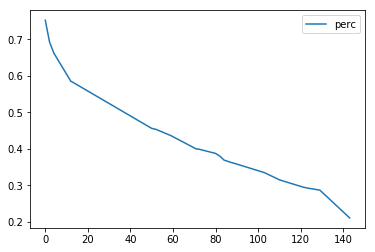

In [224]:
short_sorted_df[short_sorted_df['topic_num'] == 6].plot(y='perc')

In [201]:
from collections import Counter

In [204]:
Counter(short_sorted_df['topic_num']).most_common()

[(5, 97), (6, 21), (3, 9), (1, 7), (0, 6), (11, 5)]

## Running over the Corpus 

In [207]:
from collections import namedtuple
from collections import Counter

In [307]:
Topic = namedtuple('Topic', ['top_num', 'perc'])
BestMatch = namedtuple('BestMatch', ['page', 'top_num', 'perc'])
Book = namedtuple('Book', ['ht_id', 'top_topic', 'best_match', 'most_common_topic'])

In [342]:
def mean(lst):
    return sum(lst) / len(lst)


def volume_parser(vol):
    vol_list = []
    for page in vol.pages():
        df = page.tokenlist('body', case=False, pos=False)
        dicty = df.to_dict()
        count = dicty['count']
        clean_list = []
        for key in count.keys():
            w = key[2]
            if w not in STOPWORDS and len(w) > 2: # removing two character words
                w = w.translate(PUNCDIG_TRANSLATOR)
                if w != '':
                    clean_list += [lemmatizer.lemmatize(w)] * count[key]
                    # clean_list.append(lemmatizer.lemmatize(w) * count[key])
        vol_list.append(clean_list)
    return vol_list


def get_topic_average(sorted_list):
    dicty = {}
    for (_, x, y) in sorted_list:
        dicty.setdefault(x, []).append(y)
    topic_averages = [(x, mean(y)) for x, y in dicty.items()]
    return topic_averages

        
def analyze_corpus_with_model(other_coprus, lda_model):
    pot_match = []
    for doc_num, doc in enumerate(other_corpus):
        vector = lda_model[doc]
        # row = sorted(vector[0], key=lambda x: x[1], reverse=True)
        # topic_num, prop_topic = row[0]
        topic_num, prop_topic = max(vector[0], key=lambda x: x[1])
        if topic_num in (0, 1, 3, 5, 6, 11) and prop_topic > .04:
            pot_match.append((doc_num, topic_num, prop_topic))
    return pot_match 
    '''
    sorted_list = sorted(pot_match, key=lambda x: x[-1], reverse=True)
    return sorted_list
    '''
    
    
def corpus_parser(corpus_list, corpus_dict, ldamodel):
    other_corpus = [corpus_dict.doc2bow(text) for text in vol_list]
    sorted_list = analyze_corpus_with_model(other_corpus, ldamodel)
    best_match = max(sorted_list, key=lambda x: x[-1])
    most_common_topic = Counter([x[1] for x in sorted_list]).most_common(1).pop()
    top_topic = max(get_topic_average(sorted_list), key=lambda x: x[-1])
    return best_match, most_common_topic, top_topic
    

def file_parser(feature_reader, corpus_dict, analyzed_dict, ldamodel):
    for vol in feature_reader.volumes():
        corpus_list = volume_parser(vol)
        best_match, most_common_topic, top_topic = corpus_parser(corpus_list, corpus_dict, ldamodel)
        analyzed_dict[vol.id] = Book(vol.id, Topic(*top_topic), BestMatch(*best_match), Topic(*most_common_topic))
    return analyzed_dict
        
        
    

In [346]:
files = glob.glob('../data/test/*.bz2')
fr = FeatureReader(files)

In [344]:
fr = FeatureReader(files)
analyzed_dict = file_parser(fr, corpus_dict, {}, lda_model)

In [345]:
analyzed_dict

{'chi.086834843': Book(ht_id='chi.086834843', top_topic=Topic(top_num=11, perc=0.45379678159952164), best_match=BestMatch(page=482, top_num=6, perc=0.75225335), most_common_topic=Topic(top_num=5, perc=95)),
 'chi.098383507': Book(ht_id='chi.098383507', top_topic=Topic(top_num=6, perc=0.43777944669127467), best_match=BestMatch(page=482, top_num=6, perc=0.7522632), most_common_topic=Topic(top_num=5, perc=95)),
 'chi.096733853': Book(ht_id='chi.096733853', top_topic=Topic(top_num=11, perc=0.4523201882839203), best_match=BestMatch(page=482, top_num=6, perc=0.7523029), most_common_topic=Topic(top_num=5, perc=98)),
 'chi.100957606': Book(ht_id='chi.100957606', top_topic=Topic(top_num=11, perc=0.45268581062555313), best_match=BestMatch(page=482, top_num=6, perc=0.7522699), most_common_topic=Topic(top_num=5, perc=96)),
 'chi.19080474': Book(ht_id='chi.19080474', top_topic=Topic(top_num=11, perc=0.45268653333187103), best_match=BestMatch(page=482, top_num=6, perc=0.75227374), most_common_topic=

## Measuring Performance 

In [349]:
# Timeit
import timeit
def wrapper(func, *args, **kwargs):
    def wrapped():
        return func(*args, **kwargs)
    return wrapped

wrapped = wrapper(file_parser, fr, corpus_dict, {}, lda_model)

In [328]:
import cProfile 
cProfile.run('file_parser(fr, {}, lda_model)')

         113455374 function calls (112169090 primitive calls) in 111.892 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1610692    1.098    0.000    2.516    0.000 <frozen importlib._bootstrap>:1009(_handle_fromlist)
    71232    0.113    0.000    0.124    0.000 <frozen importlib._bootstrap>:103(release)
    71232    0.039    0.000    0.039    0.000 <frozen importlib._bootstrap>:143(__init__)
    71232    0.070    0.000    0.627    0.000 <frozen importlib._bootstrap>:147(__enter__)
    71232    0.039    0.000    0.163    0.000 <frozen importlib._bootstrap>:151(__exit__)
    71232    0.212    0.000    0.399    0.000 <frozen importlib._bootstrap>:157(_get_module_lock)
    71232    0.069    0.000    0.101    0.000 <frozen importlib._bootstrap>:176(cb)
53424/17808    0.030    0.000    2.654    0.000 <frozen importlib._bootstrap>:211(_call_with_frames_removed)
    89040    0.040    0.000    0.040    0.000 <frozen importlib._b

    21748    0.039    0.000    1.545    0.000 generic.py:4436(f)
    69184    0.045    0.000    0.084    0.000 generic.py:458(ndim)
    12972    0.063    0.000    3.464    0.000 generic.py:5009(copy)
     4324    0.023    0.000    0.406    0.000 generic.py:5125(_convert)
     4452    0.010    0.000    0.541    0.000 generic.py:6224(isnull)
     8648    0.023    0.000    0.159    0.000 generic.py:645(_set_axis)
     4324    0.036    0.000    3.665    0.001 generic.py:6592(groupby)
  3546116    1.333    0.000    1.866    0.000 generic.py:7(_check)
      128    0.000    0.000    0.019    0.000 generic.py:9577(stat_func)
     4452    0.022    0.000    0.502    0.000 generic.py:9675(logical_func)
     5740    0.010    0.000    0.015    0.000 getlimits.py:376(__new__)
     4324    0.024    0.000   15.803    0.004 groupby.py:1410(f)
     4324    0.015    0.000    3.605    0.001 groupby.py:2143(groupby)
     4324    0.010    0.000    0.011    0.000 groupby.py:2196(__init__)
     8648    0.028 

     8904    0.002    0.000    0.002    0.000 series.py:349(_constructor)
    57364    0.114    0.000    0.219    0.000 series.py:365(_set_axis)
     4452    0.009    0.000    0.550    0.000 series.py:3802(isnull)
    57364    0.032    0.000    0.032    0.000 series.py:391(_set_subtyp)
    21620    0.052    0.000    0.178    0.000 series.py:3992(_sanitize_index)
    75428    0.120    0.000    0.204    0.000 series.py:401(name)
    35488    0.180    0.000    1.790    0.000 series.py:4019(_sanitize_array)
    35488    0.063    0.000    0.542    0.000 series.py:4036(_try_cast)
    70720    0.053    0.000    0.078    0.000 series.py:405(name)
    26968    0.022    0.000    0.063    0.000 series.py:412(dtype)
     4452    0.005    0.000    0.017    0.000 series.py:432(values)
    84588    0.052    0.000    0.171    0.000 series.py:465(_values)
      128    0.000    0.000    0.001    0.000 series.py:470(_formatting_values)
    17936    0.012    0.000    0.068    0.000 series.py:476(get_value

In [350]:
timeit.timeit(wrapped, number=1)

75.40105408901582